In [1]:
initial_path = 'peptide-QML/'
# initial_path = '../'

In [2]:
day = "0804"
name_notebook = day + "-sq_1qm.ipynb"

#ask the user if that is correct, if he says yes kkep going, otherwise stop
import sys
answer = input("{} is the name of the notebook | Is that correct? (y/n): ".format(name_notebook))
if answer != "y":
    print("Please, change the name of the notebook")
    sys.exit()

In [3]:
import numpy as np

In [4]:
import sys
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import functions as f
from my_code import pytorch_model as ptm
from my_code import quantum_nodes as qn
from my_code import pytorch_wrappers as pw

# Data

In [5]:
data_file_path = initial_path + 'data/energies/PET/generated/bb14_Strings_Energies_10_000_4_aa.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(data_file_path)
score_list = np.array(number_list)/1000
vector_list = np.array([f.string_to_vector(string) for string in string_list]) # one hot encoding

In [6]:
X, Y, X_validation, Y_validation = f.create_validating_set(vector_list, score_list, percentage=0.1)

X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]) # flatten
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1]*X_validation.shape[2]) # flatten

In [7]:
# Define the dataset
input_data = ptm.torch.tensor(X, dtype=ptm.torch.float64) 
target_data = ptm.torch.tensor(Y, dtype=ptm.torch.float64).view(-1, 1)

# Define the validation set
input_validation = ptm.torch.tensor(X_validation, dtype=ptm.torch.float64)
target_validation = ptm.torch.tensor(Y_validation, dtype=ptm.torch.float64).view(-1, 1)

# Quantum node

In [8]:
n_aminoacids = len(string_list[0])

In [9]:
quantum_layer = qn.circuit(
    n_qubits = n_aminoacids, 
    device = "default.qubit.torch",
    device_options = {'shots': 10000},
    embedding = qn.parts.AngleEmbedding, 
    embedding_ansatz = qn.parts.Ansatz_11,
    block_ansatz = qn.parts.Ansatz_11,
    measurement = qn.parts.Measurement('Z', 1),
    embedding_n_layers = 3,
    block_n_layers = 25,
    wrapper_qlayer = pw.QLayer,
    # wrapper_qlayer = None,
)

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  

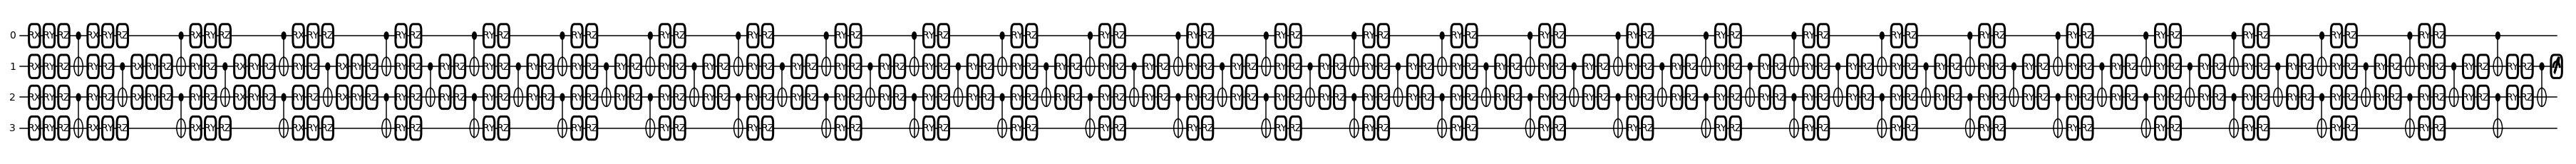

In [10]:
quantum_layer.draw(size=(50,3))

# Hybrid model

In [11]:
input_dim = input_data.size(1)

n_pre_classical_layers = 4
layers_dim = np.linspace(n_aminoacids, input_dim, 4).astype(int)

In [91]:
import torch.nn as nn
import torch
class ClippedReLU(nn.Module):
    def __init__(self, clip_val=2 * 3.141592653589793):
        super(ClippedReLU, self).__init__()
        self.clip_val = clip_val

    def forward(self, x):
        return torch.clamp(x, 0, self.clip_val)

In [92]:
layers = []
for i in range(1, len(layers_dim)):
    layers += [ptm.nn.Linear(layers_dim[-1*i], layers_dim[-1*(i+1)]), ptm.nn.ReLU()]
layers += [ptm.nn.Linear(layers_dim[0], layers_dim[0]), ClippedReLU()]
layers += [quantum_layer()]
# layers += [nn.Linear(1, 1)]
# layers += [nn.Linear(2, 4), nn.ReLU()]
# layers += [nn.Linear(4, 1)]

In [93]:
# Create model and set data:
model = ptm.pytorch_model(
    layers,    
    save_options = {'initial_path': initial_path, 'name_notebook': name_notebook},
)
model.set_data(
    data_X=input_data, 
    data_Y=target_data, 
    data_X_validation=input_validation,
    data_Y_validation=target_validation
)

In [94]:
print(model(input_data[0]))
print(model(input_data[1]))

tensor([-0.0358], grad_fn=<QNodeFunctionBackward>)
tensor([-0.0434], grad_fn=<QNodeFunctionBackward>)


In [95]:
model

Sequential(
  (0): Linear(in_features=76, out_features=52, bias=True)
  (1): ReLU()
  (2): Linear(in_features=52, out_features=28, bias=True)
  (3): ReLU()
  (4): Linear(in_features=28, out_features=4, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=4, bias=True)
  (7): ClippedReLU()
  (8): QLayer(
    (qlayer): <Quantum Torch Layer: func=circuit>
  )
)

In [99]:
for tensor in input_data:
# print('input', tensor)

    for x in model.model:
        tensor = x(tensor)

        if type(x)==ClippedReLU:
            print(tensor)

tensor([0.1339, 0.2830, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1337, 0.2820, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1344, 0.2851, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1342, 0.2840, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1341, 0.2840, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1345, 0.2859, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1336, 0.2814, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1345, 0.2857, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1338, 0.2822, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1343, 0.2846, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1338, 0.2823, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1339, 0.2825, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1352, 0.2891, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1341, 0.2837, 0.0000, 0.0000], grad_fn=<ClampBackward1>)
tensor([0.1345, 0.2859, 0.0000, 0.0000], grad_fn=<ClampBackwar

KeyboardInterrupt: 

In [15]:
model.keep_track_params=True,

In [16]:
import torch.optim as optim

# ask the user if he wants to start the training
out = input("Do you want to start the training? (y/n) ")
if out != 'y':
    sys.exit()

# train the model
model.train(
    optimizer= optim.Adam,
    optimizer_options={'lr': 0.5},
    num_epochs = 50,                
    batch_size = 32,
)

Epoch [0/50], Loss: 1.7419, Loss validation: 2.2038


/usr/lib/python3/dist-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(


	 Validation string, 	 i: 0; 	 prediction: 0.1970, 	 target: 0.1942, 	 loss: 0.0147
	 Validation string, 	 i: 1; 	 prediction: 0.1988, 	 target: 0.1944, 	 loss: 0.0224
	 Validation string, 	 i: 2; 	 prediction: 0.1738, 	 target: -0.0479, 	 loss: 4.6307
Epoch [1/50], Loss: 1.9200, Loss validation: 1.9405, Time remaining: ~2.0h 35.0m 27s
	 Validation string, 	 i: 0; 	 prediction: -0.0918, 	 target: 0.1942, 	 loss: 1.4728
	 Validation string, 	 i: 1; 	 prediction: -0.0794, 	 target: 0.1944, 	 loss: 1.4084
	 Validation string, 	 i: 2; 	 prediction: -0.0894, 	 target: -0.0479, 	 loss: 0.8676
Epoch [2/50], Loss: 2.0148, Loss validation: 1.3758, Time remaining: ~2.0h 26.0m 58s
	 Validation string, 	 i: 0; 	 prediction: 0.0784, 	 target: 0.1942, 	 loss: 0.5962
	 Validation string, 	 i: 1; 	 prediction: 0.0656, 	 target: 0.1944, 	 loss: 0.6626
	 Validation string, 	 i: 2; 	 prediction: 0.0498, 	 target: -0.0479, 	 loss: 2.0403
Epoch [3/50], Loss: 1.8027, Loss validation: 1.1049, Time remaining:

In [17]:
model.save_str(
    metadata={
        "data_file_path": data_file_path,
    }
)

Saved in:  peptide-QML/checkpoints/0804/txts/0804-sq_1qm_model_str_3.txt


Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_0.weight_None_3.png


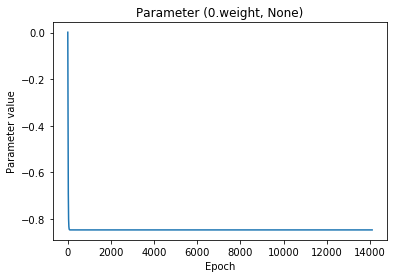

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_0.bias_None_3.png


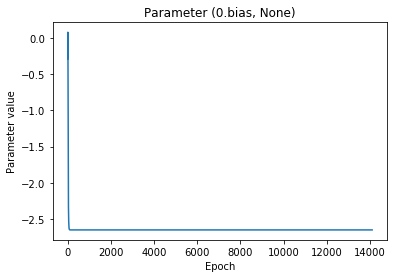

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_2.weight_None_3.png


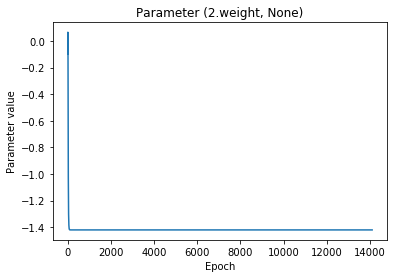

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_2.bias_None_3.png


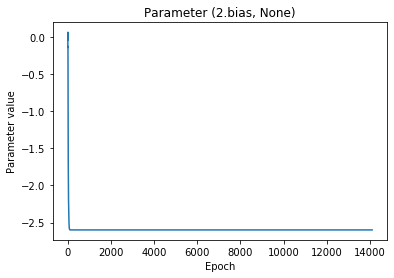

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_4.weight_None_3.png


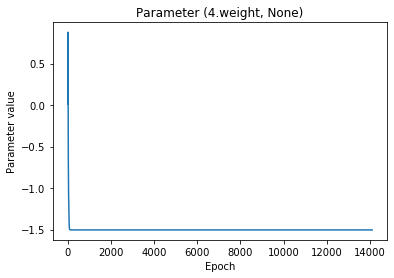

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_4.bias_None_3.png


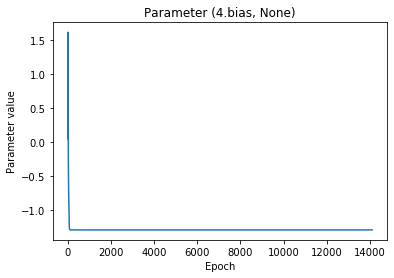

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_6.weight_None_3.png


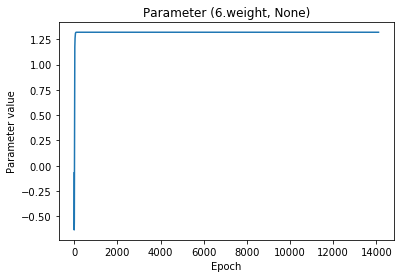

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_6.bias_None_3.png


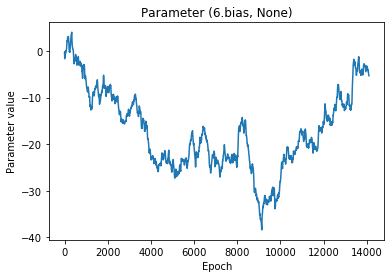

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_7.qlayer.embedding_weights_None_3.png


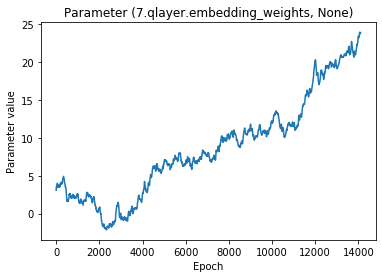

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_parameter_7.qlayer.block_weights_None_3.png


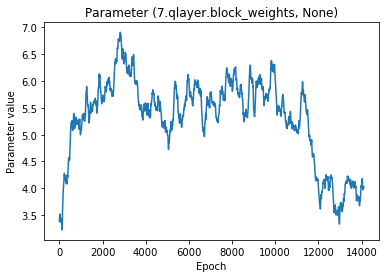

In [18]:
for layer in model.model.state_dict().keys():
    model.plot_parameter(layer=layer, save=True)

In [19]:
# model.plot_parameter(layer='7.weights', index=50)

KeyError: '7.weights'

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_losses_batches_3.png


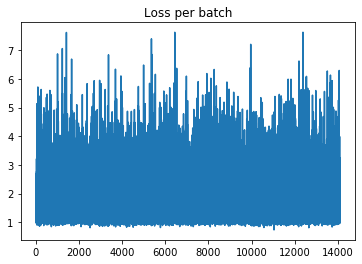

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_losses_epoch_3.png


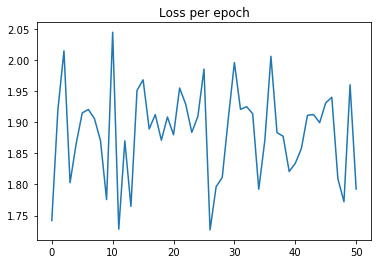

Saved in:  peptide-QML/checkpoints/0804/plots/0804-sq_1qm_losses_epoch_validation_3.png


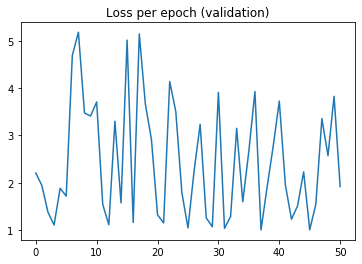

In [20]:
# plot the losses of the trainig loop
model.plot_losses(save=True)

In [21]:
model.save_state_dict(intermediate=True)

Model saved as peptide-QML/checkpoints/0804/models/0804-sq_1qm_3.pth and intermediate parameters saved in peptide-QML/checkpoints/0804/models/0804-sq_1qm_3


In [23]:
# print validation
model.print_validation(save=True, precision=4, percentatge=0.02)

i: 0, 		 target: 0.1942, 	 output: -0.1628, 	 loss: 1.8385
i: 1, 		 target: 0.0498, 	 output: -0.1668, 	 loss: 4.3505
i: 2, 		 target: -0.0692, 	 output: -0.1544, 	 loss: 1.2298
i: 3, 		 target: 0.0027, 	 output: -0.1584, 	 loss: 58.9159
i: 4, 		 target: -0.0828, 	 output: -0.1586, 	 loss: 0.9157
i: 5, 		 target: -0.0740, 	 output: -0.1494, 	 loss: 1.0180
i: 6, 		 target: 0.1907, 	 output: -0.1574, 	 loss: 1.8254
i: 7, 		 target: 0.1525, 	 output: -0.1752, 	 loss: 2.1490
i: 8, 		 target: 0.1073, 	 output: -0.1448, 	 loss: 2.3496
i: 9, 		 target: 0.1444, 	 output: -0.1896, 	 loss: 2.3132
i: 10, 		 target: 0.1944, 	 output: -0.1610, 	 loss: 1.8280
i: 11, 		 target: 0.1202, 	 output: -0.1666, 	 loss: 2.3858
i: 12, 		 target: -0.0984, 	 output: -0.1672, 	 loss: 0.6984
i: 13, 		 target: 0.1025, 	 output: -0.1468, 	 loss: 2.4325
i: 14, 		 target: -0.0545, 	 output: -0.1694, 	 loss: 2.1099
i: 15, 		 target: 0.1714, 	 output: -0.1642, 	 loss: 1.9583
i: 16, 		 target: 0.1262, 	 output: -0.1692,

In [22]:
# push changes to git
if initial_path != '../':
    !cd peptide-QML && git add . && git commit -m "data trained model" && git push

Auto packing the repository in background for optimum performance.
See "git help gc" for manual housekeeping.
[main 9d62838] data trained model
 14116 files changed, 74 insertions(+)
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_3.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_3/state_dict_00000.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_3/state_dict_00001.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_3/state_dict_00002.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_3/state_dict_00003.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_3/state_dict_00004.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_3/state_dict_00005.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_3/state_dict_00006.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_3/state_dict_00007.pth
 create mode 100644 checkpoints/0804/models/0804-sq_1qm_3/state_dict_00008.pth
 create mode 100644 checkpoints/0804/models/